In [ ]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

### (a) Plot the training and validation losses and errors as a function of the number of epochs


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

In [ ]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        if epoch == 40 and flag == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.01
          flag = 1
        if epoch == 80 and flag == 1:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.001
          flag = 2
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              # for tag, value in info.items():
              #   logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values


In [ ]:
model = allcnn_t().to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.00001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/100], Step [1000/3125], Loss: 1.7779
Epoch [1/100], Step [2000/3125], Loss: 1.4776
Epoch [1/100], Step [3000/3125], Loss: 1.1266
Accuracy of the network on the test images: 53.61 %
Epoch [2/100], Step [1000/3125], Loss: 0.8897
Epoch [2/100], Step [2000/3125], Loss: 0.7139
Epoch [2/100], Step [3000/3125], Loss: 1.4248
Accuracy of the network on the test images: 61.27 %
Epoch [3/100], Step [1000/3125], Loss: 0.7048
Epoch [3/100], Step [2000/3125], Loss: 0.5016
Epoch [3/100], Step [3000/3125], Loss: 0.7203
Accuracy of the network on the test images: 71.92 %
Epoch [4/100], Step [1000/3125], Loss: 0.6551
Epoch [4/100], Step [2000/3125], Loss: 0.9414
Epoch [4/100], Step [3000/3125], Loss: 0.5682
Accuracy of the network on the test images: 76.03 %
Epoch [5/100], Step [1000/3125], Loss: 0.3071
Epoch [5/100], Step [2000/3125], Loss: 0.1186
Epoch [5/100], Step [3000/3125], Loss: 0.3151
Accuracy of the network on the test images: 75.71 %
Epoch [6/100], Step [1000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = 'params.pth'
model = allcnn_t().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

Num parameters:  1667166


allcnn_t(
  (m): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Dropout(p=0.5, inplace=False)
    (5): Sequential(
      (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
PATH = '/content/drive/MyDrive/5460/cnn_model.pth'

torch.save(model, PATH)

model = torch.load(PATH,map_location=torch.device('cpu'))

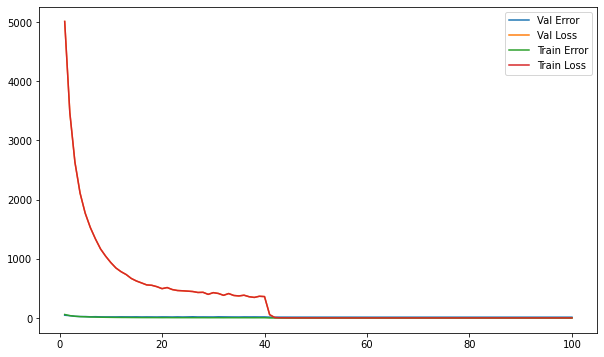

In [ ]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)
ax.plot(range(1,epochs+1),val_error,label='Val Error')
ax.plot(range(1,epochs+1),val_loss_values,label='Val Loss')
ax.plot(range(1,epochs+1),train_error,label='Train Error')
ax.plot(range(1,epochs+1),train_loss_values,label='Train Loss')

ax.legend()
plt.show()

(b)

In [ ]:
model.to(device)

allcnn_t(
  (m): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Dropout(p=0.5, inplace=False)
    (5): Sequential(
      (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
for i, (images, labels) in enumerate(testloader):
    images.requires_grad_(True)
    images.retain_grad()
    yh = model.forward(images.to(device))
    # yh = model.forward(images)
    criterion = nn.CrossEntropyLoss()
    loss = criterion.forward(yh, labels.to(device))
    # loss = criterion.forward(yh,labels)
    loss.backward()
    dx = images.grad.data.clone()
    if i > 10:
      break

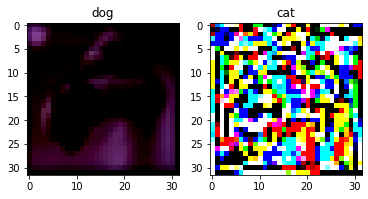

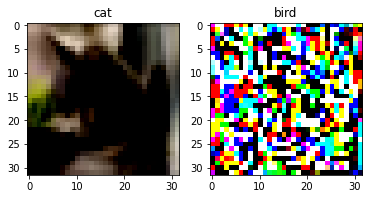

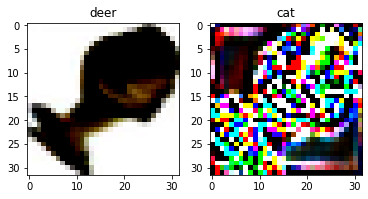

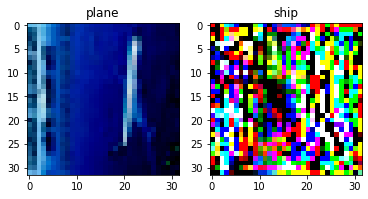

In [ ]:
for j in range(len(images)):
  if classes[int(labels[j])] != classes[yh.argmax(axis=1)[j]]:
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(np.array(images[j].detach()).swapaxes(0,2))
    ax[0].set_title(classes[int(labels[j])])
    ax[1].imshow(np.array(dx[j]*1000).swapaxes(0,2))
    ax[1].set_title(classes[yh.argmax(axis=1)[j]])

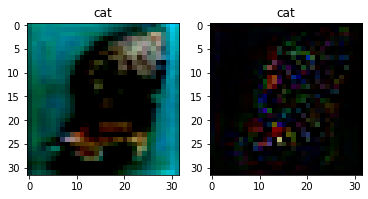

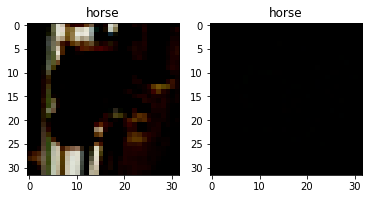

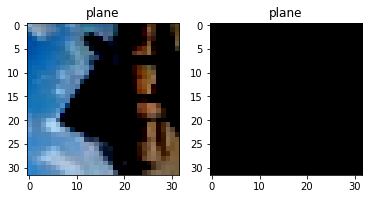

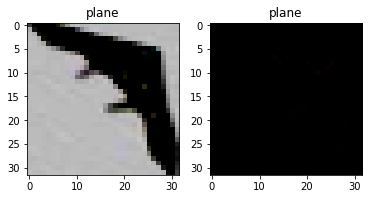

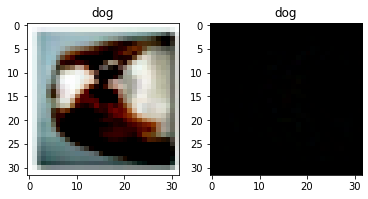

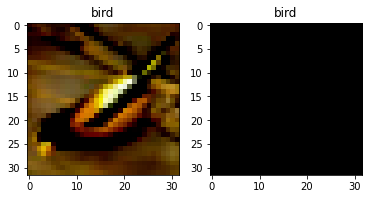

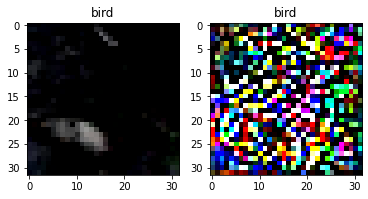

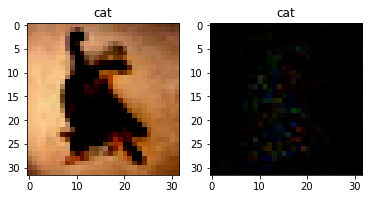

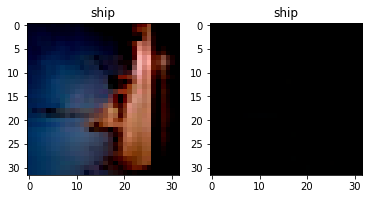

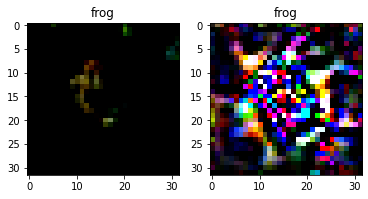

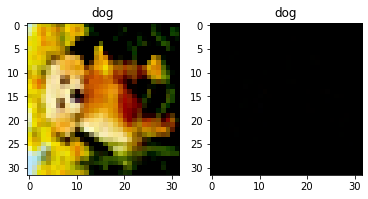

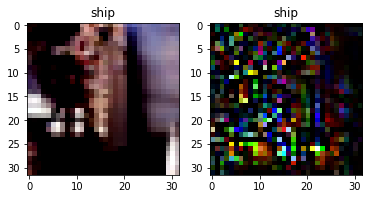

In [ ]:
for j in range(len(images)):
  if classes[int(labels[j])] == classes[yh.argmax(axis=1)[j]]:
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(np.array(images[j].detach()).swapaxes(0,2))
    ax[0].set_title(classes[int(labels[j])])
    ax[1].imshow(np.array(dx[j]*1000).swapaxes(0,2))
    ax[1].set_title(classes[yh.argmax(axis=1)[j]])

In [ ]:
eps = 8
all = []
for i, (images, labels) in enumerate(trainloader):
  for x,y in zip(images, labels):
    with torch.no_grad():
        x = torch.from_numpy(np.expand_dims(x, axis=0))
        y = torch.from_numpy(np.expand_dims(y, axis=0))
    loss1 = []
    for k in range(5):
    # forward propagate x through the network # backprop the loss
      x.requires_grad_(True)
      x.retain_grad()
      yh = model.forward(x.to(device))
      criterion = nn.CrossEntropyLoss()
      loss = criterion.forward(yh, y.to(device))
      loss.backward()
      dx = x.grad.data.clone()
      x = x + eps*np.sign(dx)
    # record loss on the perturbed image
      loss1.append(float(loss.data))
    all.append(loss1)
    if len(all) == 100:
      break
  if len(all) == 100:
    break

([<matplotlib.axis.XTick at 0x7f7f2f75a9d0>,
 <a list of 5 Text major ticklabel objects>)

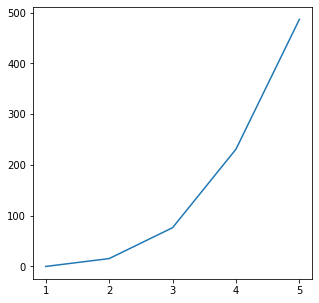

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(range(1,6,1),np.mean(np.array(all),axis=0))
plt.xticks([1,2,3,4,5])

(c)

In [ ]:
eps = 8
cle_val_error = []
per_val_error = []
correct_cle = 0
total_cle = 0
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader):
  for x,y in zip(images, labels):
    with torch.no_grad():
        x = torch.from_numpy(np.expand_dims(x, axis=0))
        y = torch.from_numpy(np.expand_dims(y, axis=0))
    
    model.eval()

    with torch.no_grad():
        outputs = model(x.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total_cle += y.size(0)
        correct_cle += (predicted == y.to(device)).sum().item()

    cle_val_error.append(100-100*correct_cle/total_cle)

    # forward propagate x through the network # backprop the loss
    x.requires_grad_(True)
    x.retain_grad()
    yh = model.forward(x.to(device))
    criterion = nn.CrossEntropyLoss()
    loss = criterion.forward(yh, y.to(device))
    loss.backward()
    dx = x.grad.data.clone()
    x = x + eps*np.sign(dx)

    model.eval()

    with torch.no_grad():
        outputs = model(x.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y.to(device)).sum().item()
    per_val_error.append(100-100*correct/total)
  print('Accuracy of the network on the clean test images: {} %'.format(100 * correct_cle / total_cle))
  print('Accuracy of the network on the perturbed test images: {} %'.format(100 * correct / total))

Accuracy of the network on the clean test images: 87.5 %
Accuracy of the network on the perturbed test images: 18.75 %
Accuracy of the network on the clean test images: 87.5 %
Accuracy of the network on the perturbed test images: 12.5 %
Accuracy of the network on the clean test images: 87.5 %
Accuracy of the network on the perturbed test images: 8.333333333333334 %
Accuracy of the network on the clean test images: 82.8125 %
Accuracy of the network on the perturbed test images: 7.8125 %
Accuracy of the network on the clean test images: 85.0 %
Accuracy of the network on the perturbed test images: 7.5 %
Accuracy of the network on the clean test images: 85.41666666666667 %
Accuracy of the network on the perturbed test images: 6.25 %
Accuracy of the network on the clean test images: 86.60714285714286 %
Accuracy of the network on the perturbed test images: 9.821428571428571 %
Accuracy of the network on the clean test images: 87.5 %
Accuracy of the network on the perturbed test images: 9.375 